In [1]:
import mlx.core as mx
import mlx
mx.set_default_device(mlx.core.DeviceType.gpu)

In [2]:
def softmax(x):
    e_x = mx.exp(x - mx.max(x, axis=0, keepdims=True))  # Subtract max for numerical stability
    return e_x / e_x.sum(axis=0, keepdims=True)

In [3]:
class Corpus():
    """A class to handle the corpus data for RNN."""
    def __init__(self, file_name):
        self.file_name = file_name
        self.data = open(file_name, 'r').read().split()
        self.vocab = self._get_vocab()
    
    def one_hot(self, word):
        index = list(self.vocab).index(word)
        return mx.eye(index + 1, len(self.vocab))[index].reshape(1, -1)
    
    def one_hot_to_word(self, one_hot_vector):
        index = mx.argmax(one_hot_vector)
        return list(self.vocab)[int(index)]
    
    def _get_vocab(self):
        self.vocab = set(self.data)
        return self.vocab

    def get_data(self):
        return self.data
    
    def get_batched_data(self, batch_size=32):
        for i in range(len(self.data) // batch_size):
            yield self.data[i * batch_size:(i + 1) * batch_size]

    def get_dim(self):
        return len(self.vocab)

In [4]:
class RNN():
    """A simple RNN implementation from scratch """
    def __init__(self, input_size, hidden_size, output_size, corpus: Corpus):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.corpus = corpus
        
        # Initialize weights
        self.Wh = mx.random.normal(shape=(hidden_size, hidden_size))
        self.Wx = mx.random.normal(shape=(hidden_size, input_size))
        self.Wy = mx.random.normal(shape=(output_size, hidden_size))
        self.bh = mx.zeros(shape=(hidden_size, 1))
        self.by = mx.zeros((output_size, 1))

        # Initialize hidden state and output
        self.x_t, self.h_t, self.y_hat = {}, {}, {}

        # Initialize gradients
        self.zero_grad()
        self.dh_next = mx.zeros((hidden_size, 1))  # Gradient of hidden state

    def zero_grad(self):
        """ Reset gradients to zero """
        self.dWh = mx.zeros_like(self.Wh)
        self.dWx = mx.zeros_like(self.Wx)
        self.dWy = mx.zeros_like(self.Wy)
        self.dbh = mx.zeros_like(self.bh)
        self.dby = mx.zeros_like(self.by)

    def forward(self, x):
        """ Forward pass through the RNN"""
        for t in range(len(x)):
            # print(f"t = {t}, x[t] = {x[t]}")
            self.x_t[t] = self.corpus.one_hot(x[t]).T
            # print(f"x_t[{t}].shape = {x_t[t].shape}")
            if t == 0:
                self.h_t[t] = self.tanh(self.Wx @ self.x_t[t] +  self.Wh @ mx.zeros((self.hidden_size, 1)) + self.bh)
            else:
                self.h_t[t] = self.tanh(self.Wx @ self.x_t[t] + self.Wh @ self.h_t[t-1] + self.bh)
            # print(f"Wy shape = {self.Wy.shape}")
            # print(f"h_t[{t}].shape = {h_t[t].shape}")
            self.y_hat[t] = softmax(self.Wy @ self.h_t[t] + self.by)
            # print(f"y_hat[{t}].shape = {y_hat[t].shape}")
            # print(f"y_hat: {self.y_hat[t]}")

        return self.y_hat
    
    def backward(self, y):
        """ Backward pass through the RNN """
        for t in reversed(range(len(y))):
            # print(f"t = {t}")
            self.dy = self.y_hat[t] - y[t] # partial deriviative of loss function of softmax values w.r.t. logits
            self.dWy += self.dy @ self.h_t[t].T
            self.dby += self.dy
            self.dh = self.Wy.T @ self.dy + self.dh_next
            self.dh_raw = (1 - self.h_t[t] ** 2) * self.dh # Derivative of tanh activation
            self.dWx += self.dh_raw @ self.x_t[t].T
            if t == 0:
                self.dWh += self.dh_raw @ mx.zeros((self.hidden_size, 1)).T
            else:
                self.dWh += self.dh_raw @ self.h_t[t-1].T
            self.dbh += self.dh_raw
            self.dh_next = self.Wh.T @ self.dh_raw

            for grad in [self.dWh, self.dWx, self.dWy, self.dbh, self.dby]:
                mx.clip(grad, -5, 5)

        return self.dWh, self.dWx, self.dWy, self.dbh, self.dby

    def step(self, learning_rate=0.01):
        """ Update weights using gradients """
        self.Wh -= learning_rate * self.dWh
        self.Wx -= learning_rate * self.dWx
        self.Wy -= learning_rate * self.dWy
        self.bh -= learning_rate * self.dbh
        self.by -= learning_rate * self.dby
        
    def sigmoid(self, x):
        return 1 / (1 + mx.exp(-x))
    
    def tanh(self, x):
        return mx.tanh(x)
    
    def relu(self, x):
        return 0 if x < 0 else x
    
    def single_loss(self, y_hat, y):
        """ Cross-entropy loss for a single output """
        return -mx.sum(y * mx.log(y_hat + 1e-12))
    
    def sequence_loss(self, y_hat, y):
        """ Cross-entropy loss """
        loss_value = 0
        for y_i, y_i_hat in zip(y, y_hat):
            loss_value += mx.sum(-1 * y_i * mx.log(y_i_hat + 1e-12)) # Adding a small value to avoid log(0)
        return loss_value / len(y_hat)

In [8]:
# Load the corpus
corpus = Corpus(file_name='sign_of_four.txt')

In [9]:
# Create an RNN instance
rnn = RNN(input_size=len(corpus.vocab), hidden_size=40, output_size=corpus.get_dim(), corpus=corpus)

In [10]:
# Print the shapes of the weights and biases
print(f"Wx = {rnn.Wx.shape}")
print(f"Wh = {rnn.Wh.shape}")
print(f"Wy = {rnn.Wy.shape}")
print(f"bh = {rnn.bh.shape}")
print(f"by = {rnn.by.shape}")
print(f"vocab size = {len(rnn.corpus.vocab)}")

Wx = (40, 9202)
Wh = (40, 40)
Wy = (9202, 40)
bh = (40, 1)
by = (9202, 1)
vocab size = 9202


In [11]:
SEQ_LENGTH = 32

batch_data = corpus.get_batched_data(batch_size=SEQ_LENGTH)

In [12]:
train_data = next(batch_data)
print(f"train_data input = {train_data[:SEQ_LENGTH-1]}")  # Exclude the last word for prediction
print(f"train_data output = {train_data[1:SEQ_LENGTH]}")  # Exclude the first word for prediction

y_hat = rnn.forward(train_data[:SEQ_LENGTH-1])

# print(f"y_hat_words = {y_hat_words}")
print(f"y_hat = {[corpus.one_hot_to_word(vector) for vector in y_hat.values()]}")  # Print the predicted outputs

# Calculate the loss
y = [corpus.one_hot(word).T for word in train_data[1:SEQ_LENGTH]]
# loss_value = rnn.single_loss(list(y_hat.values())[-1], y[-1])
loss_value = rnn.sequence_loss(list(y_hat.values()), y)
print(f"Loss: {loss_value}")

# Perform backward pass
rnn.zero_grad()
rnn.backward(y)

# Update weights
rnn.step(learning_rate=0.1)  

train_data input = ['\ufeffThe', 'Project', 'Gutenberg', 'eBook', 'of', 'The', 'Sign', 'of', 'the', 'Four', 'This', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'United', 'States', 'and', 'most', 'other', 'parts', 'of', 'the', 'world', 'at']
train_data output = ['Project', 'Gutenberg', 'eBook', 'of', 'The', 'Sign', 'of', 'the', 'Four', 'This', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'United', 'States', 'and', 'most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no']
y_hat = ['1.E.8.', 'burners,', 'Catch!—A', 'fitting', 'Forrester’s.', 'sergeant,”', 'ears.', '“Priory', 'places.', 'coils', 'mad!”', 'stanch', 'notepaper.', 'sapphires,', 'comin’,', 'III.', 'conceived', 'Just', 'something', 'iron-clamped', 'comin’,', 'men', 'Wherever', 'questions?', 'figure.', 'fitting', 'nose', '“This', 'philanthropist', 'death.', 'tint']
Loss: 22.292104721069336


In [13]:
print(mx.argmax(list(rnn.y_hat.values())[-1]))  # Get the last predicted output
print(mx.argmax(y[-1]))  # Get the last true output

array(5078, dtype=uint32)
array(7367, dtype=uint32)


In [14]:
learning_rate = 0.001
rnn_loss_history = []

index = 0
BATCH_SIZE = 32
while True:
    try:
        train_data = next(batch_data)
        index += 1
    except StopIteration:
        break
    rnn.zero_grad()
    y_hat = rnn.forward(train_data[:SEQ_LENGTH-1])
    y = [corpus.one_hot(x).T for x in train_data[1:SEQ_LENGTH]]
    # loss_value = rnn.single_loss(list(y_hat.values())[-1], y[-1])
    loss_value = rnn.sequence_loss(list(y_hat.values()), y)
    rnn_loss_history.append(loss_value)
    print(f"index = {index}, rnn_loss = {loss_value}")
    dWh, dWx, dWy, dbh, dby = rnn.backward(y)
    rnn.step(learning_rate=learning_rate)
    
    # print(f"dWh = {dWh}")
    # print(f"dWx = {dWx}")
    # print(f"dWy = {dWy}")
    # print(f"dbh = {dbh}")
    # print(f"dby = {dby}")

index = 1, rnn_loss = 24.648815155029297
index = 2, rnn_loss = 23.608951568603516
index = 3, rnn_loss = 23.460926055908203
index = 4, rnn_loss = 22.7359619140625
index = 5, rnn_loss = 22.721155166625977
index = 6, rnn_loss = 23.435583114624023
index = 7, rnn_loss = 23.74570083618164
index = 8, rnn_loss = 22.387678146362305
index = 9, rnn_loss = 22.630306243896484
index = 10, rnn_loss = 23.56233024597168
index = 11, rnn_loss = 23.011795043945312
index = 12, rnn_loss = 22.741220474243164
index = 13, rnn_loss = 23.86404800415039
index = 14, rnn_loss = 23.66274642944336
index = 15, rnn_loss = 21.49833106994629
index = 16, rnn_loss = 22.076745986938477
index = 17, rnn_loss = 21.775136947631836
index = 18, rnn_loss = 21.52452278137207
index = 19, rnn_loss = 22.242441177368164
index = 20, rnn_loss = 21.44765281677246
index = 21, rnn_loss = 21.97220230102539
index = 22, rnn_loss = 23.464126586914062
index = 23, rnn_loss = 23.23188591003418
index = 24, rnn_loss = 21.20262336730957
index = 25, r

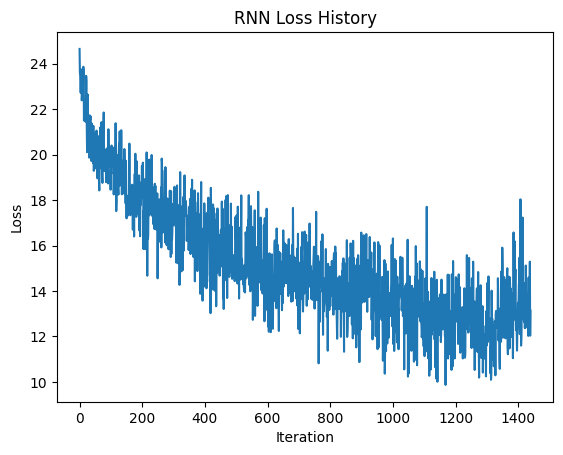

In [15]:
from matplotlib import pyplot as plt
plt.plot(rnn_loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('RNN Loss History')
plt.show()

In [16]:
y_hat = rnn.forward(train_data[:BATCH_SIZE-1])
y = [corpus.one_hot(x).T for x in train_data[1:BATCH_SIZE]]

In [17]:
print(f"y_hat = {len(y_hat)}")
print(f"y = {len(y)}")

print(f"y_hat[0].shape = {y_hat[0].shape}")
print(f"y[0].shape = {y[0].shape}")

y_hat = 31
y = 31
y_hat[0].shape = (9202, 1)
y[0].shape = (9202, 1)


In [24]:
rnn_loss = rnn.sequence_loss(y_hat, y)

In [25]:
print(f"rnn_loss = {rnn_loss}")

rnn_loss = -0.3263361155986786


In [ ]:
input_seq = ["I", "am", "a", "detective", "with", "a", "hat", "and", "a"]
print(f"Initial word: {input_seq}")
rnn.y_hat = {}
for i in range(10):
    print(f"Iteration {i+1}:")
    y_hat = rnn.forward(input_seq)
    print(f"y_hat = {[corpus.one_hot_to_word(vector) for vector in y_hat.values()]}")  # Print the predicted outputs
    next_word = corpus.one_hot_to_word(list(y_hat.values())[-1])  # Get the last predicted word
    input_seq.append(next_word)
    print(f"input sequence: {input_seq}")